In [1]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle
import scipy.misc as smi

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.path.append('/work/code/repo/d-script/')
# d-script imports
from data_iters.minibatcher import MiniBatcher
from data_iters.iam_hdf5_iterator import IAM_MiniBatcher

from fielutil import *

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
hdf5_file = '/memory/author_lines.hdf5'
num_forms_per_author=50; batch_size=32; num_authors=47; shingle_dim=(120,120); use_form=True

iam_m = IAM_MiniBatcher(hdf5_file, num_authors, num_forms_per_author, shingle_dim=shingle_dim, default_mode=MiniBatcher.TRAIN, batch_size=batch_size)
[X_test, Y_test] = iam_m.get_test_batch(batch_size*20)
X_test = np.expand_dims(X_test, 1)
X_test = randangle(X_test)
Y_test = to_categorical(Y_test, num_authors)

im = smi.imread('/fileserver/iam/forms/h07-025a.png')
im = 1.0-im/256.0
maxx, maxy = im.shape
maxx = maxx/3
maxy = maxy/3
halfim = im[ :maxx, :maxy ]
halfim = np.expand_dims( np.expand_dims( halfim, 0 ), 0 )

In [3]:
print "Loading original weights into GPU memory"
model = fielnet('../convnets/fielnet/fielnet.hdf5', layer='fc8')
model.compile(loss='mse', optimizer='sgd')
print "Finished weight load"

Loading original weights into GPU memory
Finished weight load


In [4]:
input_shape = model.input_shape
output_shape = model.output_shape[1]
im = halfim[0]
vskip = 2
hskip = 2

obufx = (im.shape[1]-input_shape[2])/vskip+1
obufy = (im.shape[2]-input_shape[3])/hskip+1
obuflen = obufx*obufy
ibuflen = 3200
# input_buffer = np.zeros((obuflen, 1, input_shape[2], input_shape[3]))
input_buffer = np.zeros((ibuflen, 1, input_shape[2], input_shape[3]))
output_buffer = np.zeros( (obuflen, output_shape) )

In [5]:
import sys
print "Begin data transfer to buffers"
k = 0; lb=0; le=0
for i in xrange(0, im.shape[1] - input_shape[2] + vskip, vskip):
    for j in xrange(0, im.shape[2] - input_shape[3] + hskip, hskip):
        input_buffer[k] = im[:, i:(i+input_shape[2]), j:(j+input_shape[3])]
        k+=1; le+=1;
        # Dump buffer and do inference
        if k==ibuflen:
            output_buffer[lb:le] = model.predict( input_buffer )
            pctdone = float(le)/obuflen*100
            sys.stdout.write("\033[F") # Cursor up one line
            print ("Finished output_buffer fill (%d - %d) / %d : %f %%" %( lb, le, obuflen, float(le)/obuflen*100 ))
            k=0; lb=le

Begin data transfer to buffers
Finished output_buffer fill (0 - 3200) / 187974 : 1.702363 %
Finished output_buffer fill (3200 - 6400) / 187974 : 3.404726 %
Finished output_buffer fill (6400 - 9600) / 187974 : 5.107089 %
Finished output_buffer fill (9600 - 12800) / 187974 : 6.809452 %
Finished output_buffer fill (12800 - 16000) / 187974 : 8.511815 %
Finished output_buffer fill (16000 - 19200) / 187974 : 10.214179 %
Finished output_buffer fill (19200 - 22400) / 187974 : 11.916542 %
Finished output_buffer fill (22400 - 25600) / 187974 : 13.618905 %
Finished output_buffer fill (25600 - 28800) / 187974 : 15.321268 %
Finished output_buffer fill (28800 - 32000) / 187974 : 17.023631 %
Finished output_buffer fill (32000 - 35200) / 187974 : 18.725994 %
Finished output_buffer fill (35200 - 38400) / 187974 : 20.428357 %
Finished output_buffer fill (38400 - 41600) / 187974 : 22.130720 %
Finished output_buffer fill (41600 - 44800) / 187974 : 23.833083 %
Finished output_buffer fill (44800 - 48000) / 

In [6]:
output_map = output_buffer.reshape(obufx, obufy, output_shape)

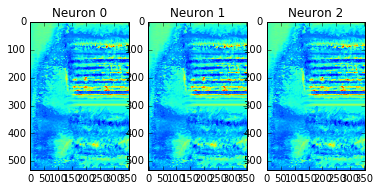

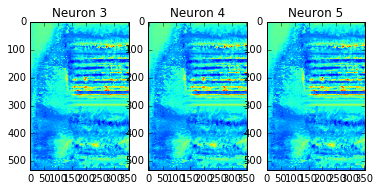

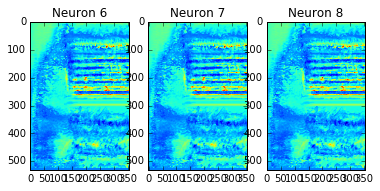

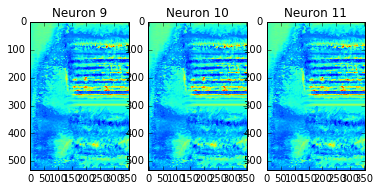

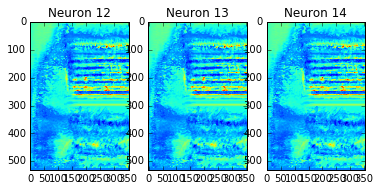

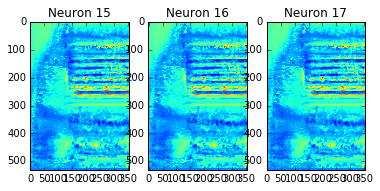

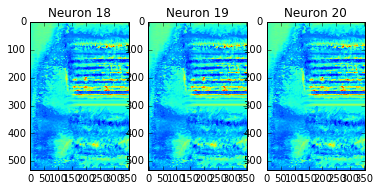

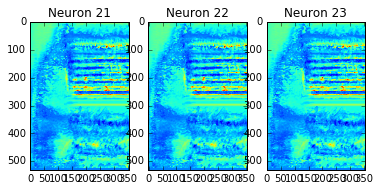

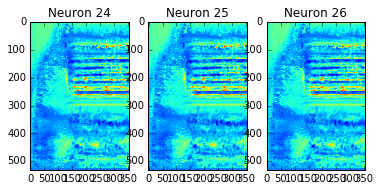

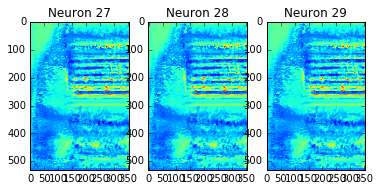

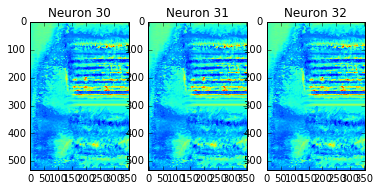

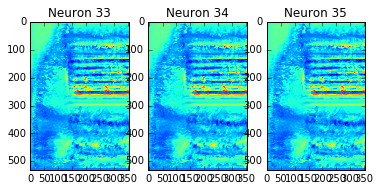

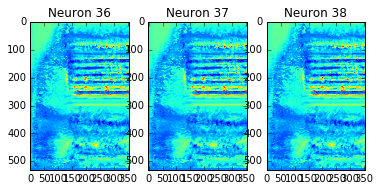

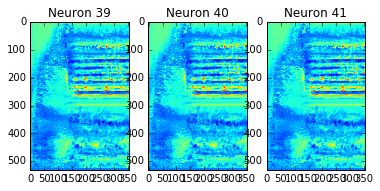

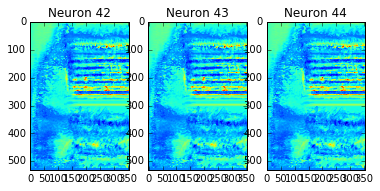

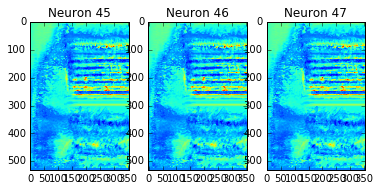

In [7]:
numcols = 3
numrows = 16

k = 0
for j in xrange(numrows):
    plt.figure()
    for i in xrange(numcols):
        if k < output_shape:
            plt.subplot(1,numcols,i+1)
            plt.imshow(output_map[:,:,k]) #,aspect='auto')
            plt.title('Neuron '+str(j*numcols+i))
            # plt.colorbar()